In [1]:
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score,
                                     completeness_score)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, ARGVA
from torch_geometric.utils import train_test_split_edges
import matplotlib.pyplot  as plt
import seaborn as sns
import networkx as nx


In [2]:
from torch_geometric.data import Data
import pandas as pd
import numpy as np


In [3]:
jpet_edge_index = pd.read_csv('jpet/data.csv')
jpet_adjmatrix = pd.read_csv('weight.csv',index_col=0)


edge_index  = torch.tensor(jpet_edge_index.values,dtype=torch.long)
x = torch.tensor(jpet_adjmatrix.values, dtype=torch.float)
data = Data(x=x, edge_index=edge_index.t().contiguous())
data

Data(edge_index=[2, 67], x=[36, 36])

In [4]:
data.edge_index

tensor([[ 1,  2,  2,  3,  3,  3,  3,  5,  7,  7,  9,  9, 10, 10, 10, 11, 11, 11,
         11, 11, 12, 12, 12, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 16, 16, 16,
         16, 17, 17, 17, 17, 17, 17, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 20,
         21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 31, 32, 32],
        [ 4,  1,  5,  2,  5,  7,  8,  1,  1,  5,  0, 27,  3, 28, 29,  1, 30, 31,
         32, 34,  8, 23, 24, 25, 26,  6, 33,  2, 35,  4, 31,  1,  4,  6, 11, 13,
         15,  0,  3,  9, 10, 11, 14,  8, 12,  1,  5,  7, 16,  4,  8, 16, 18, 22,
          3,  7,  8, 17, 19, 20,  1,  4,  6, 16, 33, 31, 34]])

In [5]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [6]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)
data

Data(test_neg_edge_index=[2, 2], test_pos_edge_index=[2, 2], train_neg_adj_mask=[36, 36], train_pos_edge_index=[2, 38], val_neg_edge_index=[2, 1], val_pos_edge_index=[2, 1], x=[36, 36])

In [7]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv_mu = GCNConv(hidden_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [8]:
encoder = Encoder(data.num_features, hidden_channels=32, out_channels=32)
discriminator = Discriminator(in_channels=32, hidden_channels=64,
                              out_channels=32)
model = ARGVA(encoder, discriminator)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = model.to(device), data.to(device)

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
                                           lr=0.001)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)

In [9]:
def train():
    model.train()
    encoder_optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)

    for i in range(5):
        discriminator.train()
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z)
        discriminator_loss.backward()
        discriminator_optimizer.step()

    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    encoder_optimizer.step()
    return loss

In [10]:
@torch.no_grad()
def test():
    G=nx.from_pandas_adjacency(jpet_adjmatrix, create_using = nx.karate_club_graph())
    G = nx.relabel_nodes(G, { n:str(n) for n in G.nodes()})
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    # Cluster embedded values using k-means.
    cluster_input = z.cpu().numpy()
    
    #Kmeans
   
    #kmeans = KMeans(n_clusters=3, random_state=0).fit(cluster_input)
    
    #hier
    #ag = AgglomerativeClustering(n_clusters=3)
    #aoc = ag.fit(cluster_input)
    
    #EM
    gmm = GaussianMixture(n_components=3, random_state=0).fit(cluster_input)
    gmm_labels = gmm.predict(cluster_input)
    
    for n, label in zip(jpet_adjmatrix.index.values, gmm_labels):
            G.nodes[n]['label'] = label
    
    plt.figure(figsize=(12, 6))
    nx.draw_networkx(G, pos=nx.layout.spring_layout(G), 
                 node_color=[n[1]['label'] for n in G.nodes(data=True)], 
                 cmap=plt.cm.rainbow)
    plt.axis('off')
    
    result_data = np.array([n for n in G.nodes(data=True)])
    
    result_pd = pd.DataFrame(result_data)
    
    result_pd.to_csv("EM_data.csv")
    
    
    plt.savefig('no_abstract_E.png')
    plt.show()


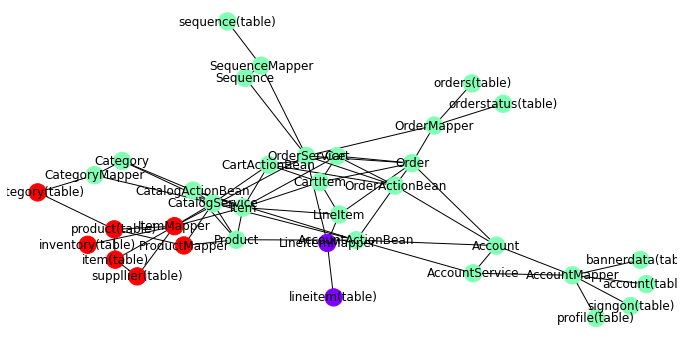

In [13]:
for epoch in range(1, 220):
    train()

test()